# **Physical annealing**

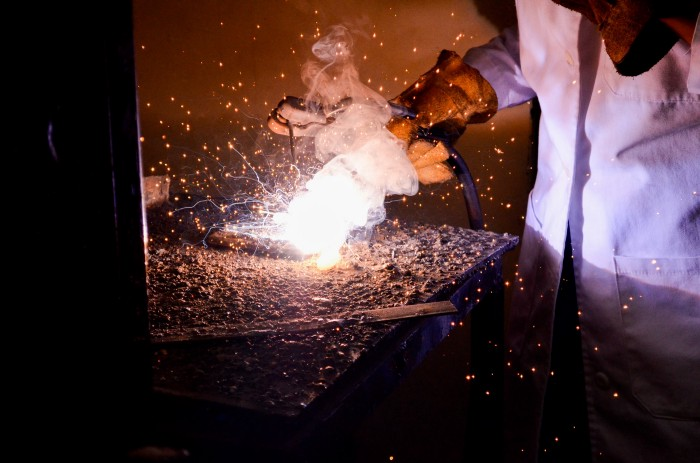

The **Simulated Annealing algorithm** is based upon Physical Annealing in real life. Physical Annealing is the process of heating up a material until it reaches an annealing temperature and then it will be cooled down slowly in order to change the material to a desired structure. When the material is hot, the molecular structure is weaker and is more susceptible to change. When the material cools down, the molecular structure is harder and is less susceptible to change.

# **Step 1:** We first start with an **initial solution s = S₀**. This can be any solution that fits the criteria for an acceptable solution. We also start with an **initial temperature t = t₀**.

# **Step 2:** Setup a temperature reduction function alpha. There are usually 3 main types of temperature reduction rules:

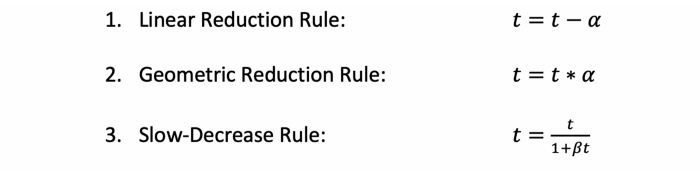

# Each reduction rule reduces the temperature at a different rate and each method is better at optimizing a different type of model. For the 3rd rule, **beta** is an arbitrary constant.

# **Step 3:** Starting at the initial temperature **t0**, loop through **n iterations** of Step 4 and then decrease the temperature according to **alpha**. Stop this loop until the termination conditions are reached. 

#The termination conditions could be reaching some end temperature, reaching some acceptable threshold of performance for a given set of parameters, etc. The mapping of time to temperature and how fast the temperature decreases is called the **Annealing Schedule**.

# **Step 4:** Given the neighbourhood of solutions **N(s)**, pick one of the solutions and calculate the difference in cost between the old solution and the new neighbour solution. The neighbourhood of a solution are **all solutions that are close to the solution**. For example, the neighbourhood of a set of 5 parameters might be if we were to change one of the five parameters but kept the remaining four the same.

# **Step 5:** If the difference in cost between the old and new solution is less than 0 (the new solution is better), then accept the new solution. If the difference in cost is greater than 0 (the old solution is better), then generate a random number between 0 and 1 and accept it if it’s under the value calculated from the Energy Magnitude equation as below: 

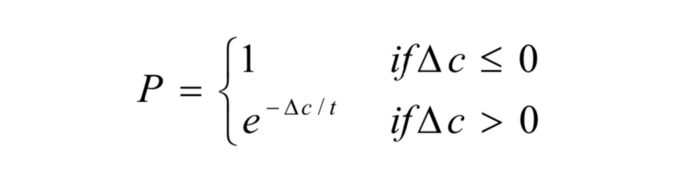

# Where the **delta c** is the change in cost and the **t** is the current temperature. The **P** calculated in this case is the probability that we should accept the new solution.

# **High vs. Low Temperature**
# Due to the way the probability is calculated, when the temperature is higher, is it more likely that the algorithm accepts a worse solution. This promotes **Exploration** of the search space and allows the algorithm to more likely travel down a sub-optimal path to potentially find a global minimum.

# When the temperature is lower, the algorithm is less likely or will not to accept a worse solution. This promotes **Exploitation** which means that once the algorithm is in the right search space, there is no need to search other sections of the search space and should instead try to converge and find the global minimum.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
cd='/content/drive/My Drive/Colab Notebooks/'
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [ ]:
import math
import random
import visualize_tsp
import matplotlib.pyplot as plt

In [ ]:
class SimAnneal(object):
    def __init__(self, coords, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        self.coords = coords
        self.N = len(coords) #N is the number of cities
        self.T = math.sqrt(self.N) if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
        self.alpha = 0.995 if alpha == -1 else alpha
        self.stopping_temperature = 1e-8 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1 # a counter for iterations

        self.nodes = [i for i in range(self.N)] #each node is a city

        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []

    def initial_solution(self):
        """
        Greedy algorithm to get an initial solution (closest-neighbour).
        """
        cur_node = random.choice(self.nodes)  # start from a random node
        solution = [cur_node]

        free_nodes = set(self.nodes)
        free_nodes.remove(cur_node)
        while free_nodes:
            next_node = min(free_nodes, key=lambda x: self.dist(cur_node, x))  # nearest neighbour
            free_nodes.remove(next_node)
            solution.append(next_node)
            cur_node = next_node

        cur_fit = self.fitness(solution)
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        return solution, cur_fit

    def dist(self, node_0, node_1):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = self.coords[node_0], self.coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

    def fitness(self, solution):
        """
        Total distance of the current solution path.
        """
        cur_fit = 0
        for i in range(self.N):
            #a=b%c  a contains the rest of the division, % is the Modulus operator
            cur_fit += self.dist(solution[i % self.N], solution[(i + 1) % self.N]) 
            #example if N=4, it will calculates the distance as follows
            # i=0 dist(0,1)
            # i=1 dist(1,2)
            # i=2 dist(2,3)
            # i=3 dist(3,0)
        return cur_fit

    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current.
        Depends on the current temperature and difference between candidate and current.
        """
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current.
        Accept with probabilty p_accept(..) if candidate is worse.
        """
        candidate_fitness = self.fitness(candidate)
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate

    def anneal(self):
        """
        Execute simulated annealing algorithm.
        """
        # Initialize with the greedy solution.
        self.cur_solution, self.cur_fitness = self.initial_solution()

        print("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            candidate = list(self.cur_solution) 
            #random.randint(start, stop) returns a integer value betwwen start and stop
            l = random.randint(2, self.N - 1)
            i = random.randint(0, self.N - l)
            candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
            #example candidate=[1,2,3,4,5]
            #l=4 and i= 0 ==> candidate[i : (i + l)]=[1,2,3,4]
            #reversed(candidate[i : (i + l)])=[4,3,2,1]
            #candidate=[4,3,2,1,5]
            self.accept(candidate)
            self.T *= self.alpha #Appy the geometric temprature reduction rule
            self.iteration += 1

            self.fitness_list.append(self.cur_fitness)

        print("Best fitness obtained: ", self.best_fitness)
        improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
        print(f"Improvement over greedy heuristic: {improvement : .2f}%")

    def batch_anneal(self, times=10):
        """
        Execute simulated annealing algorithm `times` times, with random initial solutions.
        """
        for i in range(1, times + 1):
            print(f"Iteration {i}/{times} -------------------------------")
            self.T = self.T_save
            self.iteration = 1
            self.cur_solution, self.cur_fitness = self.initial_solution()
            self.anneal()

    def visualize_routes(self):
        """
        Visualize the TSP route with matplotlib.
        """
        visualize_tsp.plotTSP([self.best_solution], self.coords)

    def plot_learning(self):
        """
        Plot the fitness through iterations.
        """
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel("Fitness")
        plt.xlabel("Iteration")
        plt.show()

In [ ]:
def read_coords(path):
    coords = []
    with open(path, "r") as f:
        for line in f.readlines():
            line = [float(x.replace("\n", "")) for x in line.split(" ")]
            coords.append(line)
    return coords

In [ ]:
def generate_random_coords(num_nodes):
    return [[random.uniform(-1000, 1000), random.uniform(-1000, 1000)] for i in range(num_nodes)]

Starting annealing.
Best fitness obtained:  624.2254501450307
Improvement over greedy heuristic:  13.15%


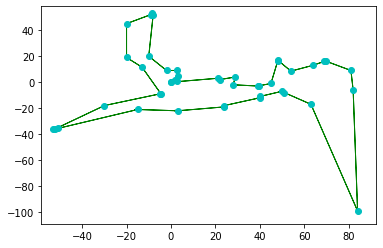

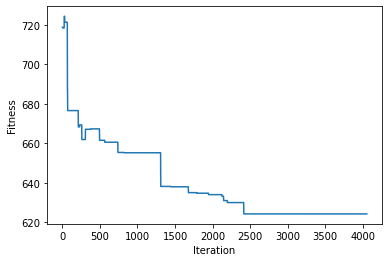

In [ ]:
if __name__ == "__main__":
    path='/content/drive/MyDrive/Colab Notebooks/coord.txt'
    coords = read_coords(path)  # or call generate_random_coords(100)
    sa = SimAnneal(coords, stopping_iter=5000)
    sa.anneal()
    sa.visualize_routes()
    sa.plot_learning()